In [7]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw, ImageColor
import numpy as np
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_masks(image, masks):
    # Create a color map for the masks
    color_map = {}
    for i in range(masks.shape[0]):
        color_map[i] = ImageColor.getrgb(f'hsl({i/float(masks.shape[0])*360},100%,50%)')

    # Create a transparent image to overlay the masks on
    mask_overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))

    # Loop over the masks and draw them on the mask overlay
    for i in range(masks.shape[0]):
        mask = masks[i, :, :]
        color = color_map[i]
        mask_overlay_draw = ImageDraw.Draw(mask_overlay)
        mask_overlay_draw.bitmap((0, 0), transforms.ToPILImage()(mask), fill=color)

    # Blend the mask overlay with the original image using alpha blending
    image_alpha = image.copy().convert('RGBA')
    image_alpha.putalpha(128)
    image_blend = Image.alpha_composite(image_alpha, mask_overlay)

    return image_blend.convert('RGB')       

In [ ]:
 

# Define the COCO dataset and data loader
coco_dataset = torchvision.datasets.CocoDetection(root='val2017/', annFile='./annotations/captions_val2017.json',
                                                  transform=transforms.ToTensor())
coco_loader = DataLoader(coco_dataset, batch_size=1, shuffle=False)

# Load the pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Put the model in evaluation mode
model.eval()

In [ ]:
# Loop over the images in the dataset and process them with the model
for i, (image, target) in enumerate(coco_loader):
    # Convert the image to a PIL Image object
    image = transforms.ToPILImage()(image[0])
    
    # Run the image through the model to obtain the predictions
    with torch.no_grad():
        prediction = model([transforms.ToTensor()(image)])
        
        
        # Convert the tensor to a numpy array
        image_np = torch.Tensor.cpu(transforms.ToTensor()(image)).numpy()
        # Convert the numpy array to uint8
        image_np_uint8 = (image_np * 255).astype('uint8')
        result = draw_segmentation_masks(torch.from_numpy(image_np_uint8),
                                         masks = prediction[0]['masks'].squeeze(1) > 0.5,
                                         alpha=0.9)
        show(result)
        #masks = prediction[0]['masks'] > 0.5  # threshold the masks
        #image_with_masks = draw_masks(image, masks)

        # Plot the image with the masks
        #image_with_masks.show()
    if i == 3:
        break
    # Print the predicted class labels and bounding boxes for the image
    #print(prediction[0]['labels'])
    #print(prediction[0]['boxes'])

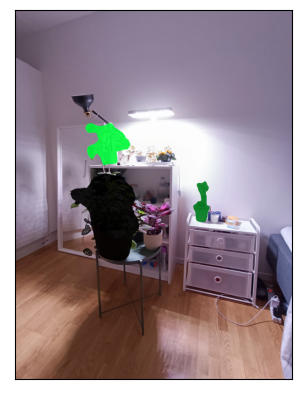

In [16]:
image = Image.open('room.jpg')
# Downscale the image
new_size = (int(image.size[0]/3), int(image.size[1]/3))
image = image.resize(new_size)
# Run the image through the model to obtain the predictions
with torch.no_grad():
    prediction = model([transforms.ToTensor()(image)])
    indices = torch.nonzero(prediction[0]['scores'] > 0.90, as_tuple=False).squeeze(1)

    # Convert the tensor to a numpy array
    image_np = torch.Tensor.cpu(transforms.ToTensor()(image)).numpy()
    # Convert the numpy array to uint8
    image_np_uint8 = (image_np * 255).astype('uint8')
    result = draw_segmentation_masks(torch.from_numpy(image_np_uint8),
                                     masks = prediction[0]['masks'][indices].squeeze(1) > 0.5,
                                     alpha=0.9)
    
    #result = draw_bounding_boxes(torch.from_numpy(image_np_uint8),
    #                             prediction[0]['boxes'][indices])
    show(result)

In [17]:
transforms.ToTensor()(image).shape

torch.Size([3, 1093, 821])

In [15]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw, ImageColor
import numpy as np
import cv2
plt.rcParams["savefig.bbox"] = 'tight'


def load_maskrcnn():
    # Define the COCO dataset and data loader
    coco_dataset = torchvision.datasets.CocoDetection(root='val2017/', annFile='annotations/captions_val2017.json',
                                                      transform=transforms.ToTensor())
    coco_loader = DataLoader(coco_dataset, batch_size=1, shuffle=False)

    # Load the pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # Put the model in evaluation mode
    model.eval()
    return model


def feedforward(model, image):
        # Convert the frame to a NumPy array
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # change color space if necessary
        image = Image.fromarray(image)
        image = image.resize((720, 480))
        # Convert the NumPy array to a PyTorch tensor
        image_tensor = torch.from_numpy([transforms.ToTensor()(image)]).unsqueeze(0)
        prediction = model(image_tensor.float() / 255.0)
        
        # Convert the numpy array to uint8
        image_np = torch.Tensor.cpu(transforms.ToTensor()(image)).numpy()
        # Convert the numpy array to uint8
        image_np_uint8 = (image_np * 255).astype('uint8')
        result = draw_segmentation_masks(torch.from_numpy(image_np_uint8),
                                         masks = prediction[0]['masks'].squeeze(1) > 0.5,
                                         alpha=0.9)
        
        result = result.detach()
        result = F.to_pil_image(result)
        
        return result
    
    
def PIL_to_cv2(image):    
        # Convert the PIL image to a NumPy array in BGR format
        output_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        return output_np


# Connect to a live stream
stream_url = "rtmp://192.168.25.1:8082/live"
model = load_maskrcnn()

# Create an OpenCV video capture object to decode the frames from the stream
#cap = cv2.VideoCapture(stream_url)
cap = cv2.VideoCapture("../vidroom.mp4")

# Define the codec and output format for the processed video
fourcc = cv2.VideoWriter_fourcc(*"XVID")
fps = 25.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#out = cv2.VideoWriter("output.avi", fourcc, fps, (width, height))

# Create a VLC HTTP or RTP stream for the output video
# Example for RTP:
#vlc_url = "rtp://127.0.0.1:1234/out_stream"
# Example for HTTP:
# vlc_url = "http://127.0.0.1:8080/"

# Loop over the frames in the stream, process them, and write them to the output video
while cap.isOpened():
    # Read the next frame from the stream
    ret, frame = cap.read()
    if not ret:
        break
    # Process the frame with PyTorch
    result = feedforward(model, frame)
    break

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


TypeError: expected np.ndarray (got list)

In [13]:
frame.shape

(1920, 1080, 3)

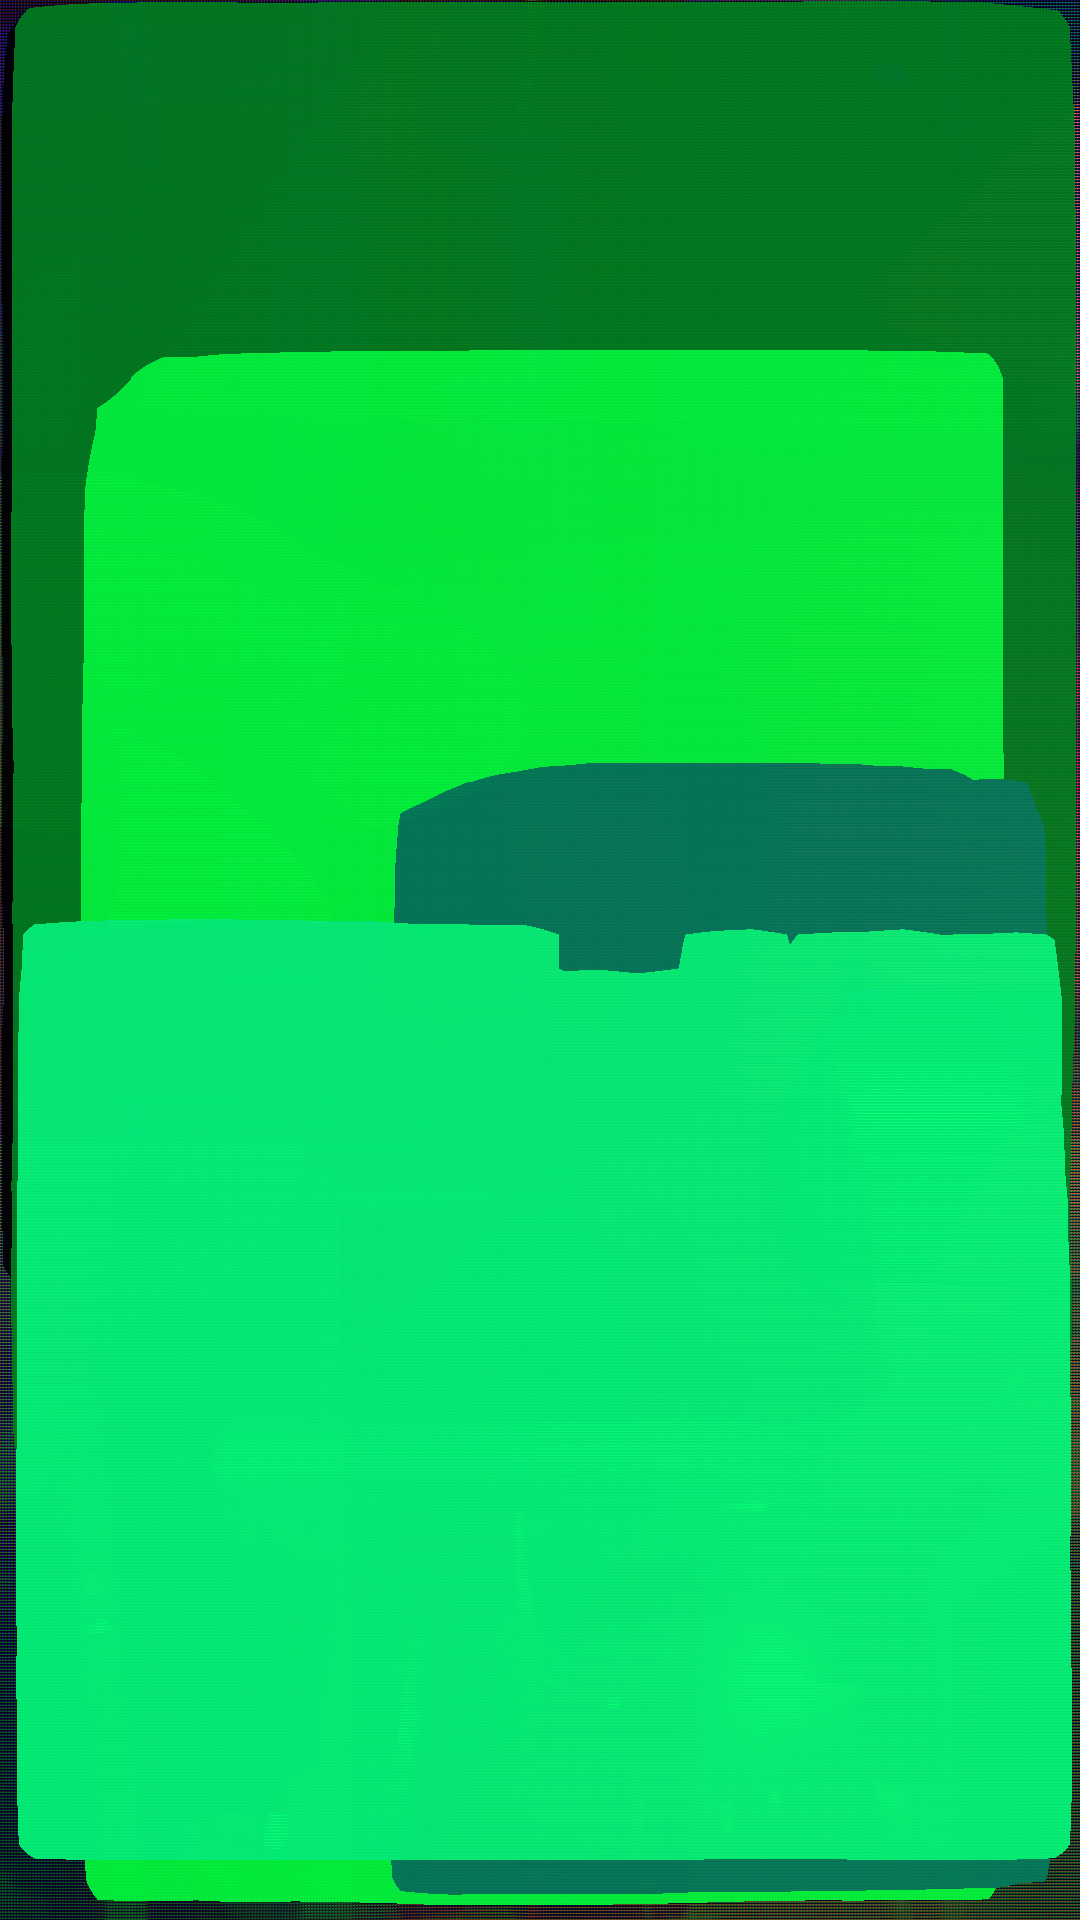

In [6]:
result